In [92]:
import pandas as pd
import numpy as np
import GPy

import seaborn as sns

%matplotlib inline

In [9]:
cd ../../../data/helpers/skills

/Users/Logan/Google Drive/Oxford/DPhil/future_employment/data/helpers/skills


In [10]:
X = pd.read_csv('skills_2009.csv')
Y = pd.read_csv('automation_targets.csv')
codes = pd.read_csv('codes_index.csv')
y = pd.read_csv('automation_y.csv')

In [1]:
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA

## UNSOLVED
# Using time series data – multiple years

## NOTES ABOUT GP MODELS
# optimize hyperparameters
# perform random restarts
# allow for multiple kernels
# optimize kernels
# optimize variances

## TO DO
# percentile regression model evaluation

# CREATE REGRESSION MODELS
from GPy.models import GPRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from GPy.models import GPClassification
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

In [2]:
reg_models = [GPRegression,
			  BayesianRidge(),
			  GradientBoostingRegressor(),
			  SVR()
			 ]

# CREATE CLASSIFICATION MODELS
class_models = [GPClassification,
				RidgeClassifier(),
				GradientBoostingClassifier(),
				SVC(),
				BernoulliNB()
		 		]

In [5]:
# CREATE INPUTS LIST
def get_array_percentiles(array):
		def percentile(x, array):
			return 100*np.mean(array <= x)

		return np.array(map(lambda x: percentile(x, array), array))

def get_percentiles(df):
	if isinstance(df, pd.DataFrame):
		new_df = df.copy()
		return new_df.apply(lambda x: get_array_percentiles(x), axis = 0)
	elif isinstance(df, np.ndarray):
		return np.apply_along_axis(get_percentiles, 0, a)
	else:
		print "TYPE ERROR; PLEASE INPUT pd.DataFrame OR np.ndarray"
		raise

In [179]:
X = pd.read_csv("skills_2009.csv")
X_skills, X_task, X_context = X, X, X
# X_skills = pd.read_csv("X_skills.csv")
# X_task = pd.read_csv("X_task.csv")
# X_context = pd.read_csv("X_context.csv")

In [180]:
Y = pd.read_csv("automation_targets.csv")
Y.columns = ["O*NET-SOC Code", "auto_15", "auto_9", "delta", "auto_delta_pct", "title"]

In [181]:
codes = pd.read_csv("codes_index.csv")
full_X = pd.concat((X_skills, codes), axis = 1)

In [182]:
full_X = full_X.merge(Y, on = "O*NET-SOC Code")

In [196]:
inputs = []
for dX in [full_X]:
    pctiles = get_percentiles(dX)
    d_list =  [('dx', dX), ('pctile', pctiles)]
    for d in d_list:
        prefix = d[0]
        data = d[1]
        inputs.append((prefix, data))
        inputs.append((prefix + '_greater_than', data[data.auto_delta_pct > 0]))
        inputs.append((prefix + '_less_than', data[data.auto_delta_pct < 0]))
# 		inputs.append(data[emp_delta_pct > 0])
# 		inputs.append(data[emp_delta_pct < 0])

# new_inputs = []
# for inp in inputs:
#     new_inputs.append(inp[0], inp[1].iloc[:,:-6])

# inputs = new_inputs

In [111]:
automation = pd.read_csv("automation_targets.csv")
codes = automation['O*NET-SOC Code']
automation = automation.iloc[:, [0,2,1]]

In [113]:
full_X = full_X.drop(["auto_15", "auto_9", "delta", "auto_delta_pct", "title"], axis = 1)


In [118]:
temp_X = full_X.merge(automation, how = 'inner', on = 'O*NET-SOC Code')
y_out = temp_X[['automation_9', 'automation_15']]
codes = temp_X["O*NET-SOC Code"]
full_X = temp_X.drop(['O*NET-SOC Code', 'automation_9', 'automation_15'], axis = 1)

In [ ]:
# automation = pd.read_csv("y_automation.csv")
# computerisation = pd.read_csv("y_computerisation.csv")

In [164]:
# CREATE CLASS TARGETS
class_targets = []
pos_threshold_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00]
neg_threshold_values = map(lambda x: -x, pos_threshold_values)
threshold_values = pos_threshold_values + neg_threshold_values

for name, target in reg_targets:
    for sd_threshold_value in threshold_values:
        low_threshold = target > (np.mean(target) - sd_threshold_value*np.std(target))
        new_name = str(sd_threshold_value)+"_gt_" + name
        class_targets.append((new_name,low_threshold))

# 	mean_threshold = target > np.mean(target)
# 	new_name = 'mean_gt_' + name
# 	class_targets.append((name, mean_threshold))

In [200]:
X_inputs = inputs
y_inputs_reg, y_inputs_class = reg_targets, class_targets
models_reg, models_class = reg_models, class_models

In [206]:
#### aggregate models as list of tuples [(name, val), (name, val)]
# loop

def run_loop(X_inputs, y_inputs_reg, y_inputs_class, models_reg, models_class):
    ## returns all models in comparison, as dict
    evals = defaultdict(defaultdict({}))
    for X_inp in X_inputs: #FOR ALL INPUTS
        X_name, X = X_inputs[0], X_inputs[1]

        for pred_type in ['classification', 'regression']:
            if pred_type == 'regression':
                y_inps = y_inputs_reg
                mods = models_reg
            elif pred_type == 'classification':
                y_inputs = y_inputs_class
                mods = models_class
            else:
                return "SOMETHING WRONG!"
        # do regression
        for y_inp in y_inps: #FOR ALL TARGETS
            # format data
            y_name, y = y_inp[0], y_inp[1]
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            data = [X_train, X_test, y_train, y_test]
            new_data = []
            # check that all data is np.ndarry
            for d in data:
                if not isinstance(data, np.ndarray):
                    new_data.append(np.array(data))
                else:
                    new_data.append(data)
            X_train, X_test, y_train, y_test = new_data

            #loop over models
            for mod in mods: #FOR APPROPRIATE MODELS
                model_name, model = models[0], models[1]

                try:
                    model.fit(X_train, y_train)
                except AttributeError:
                    model = model(X_train, y_train) # THESE ARE GPs!
                    model.optimize()
                    model.optimize_restarts(20)
                y_pred = model.predict(X_test)
                score = score_model(y_pred, y_test, X_inp, mod, score_type = pred_type) # CREATE TYPES
                evals[y_name][model_name][X_name] = score
            
            # do classification
	return evals


In [202]:
def do_ARD(model, feature_names):
	# uses ARD to find relevant features
	length_scales = model.length_scales # np.ndarray
	features = range(1, len(model.features) + 1)
	importances = 1./length_scales
	cutoff = 0.25 * min(importances) # note: arbitrary
	important_features = features * (importances >= cutoff)
	if_indices = np.trim_zeros(important_features)
	return zip(feature_names[if_indices], importances[if_indices])

In [201]:
def score_model(y_pred, y_test, model_inputs, model, score_type):
	score = {}
	X_name, X = model_inputs[0], model_inputs[1]
	model_name, model = models[0], models[1]

	if score_type == "classification":
		accuracy = -1
		precision = None
		recall = None
		specificity = None
		f1 = None
		ideal_cutoff = None

		chart_storage = np.array([None, None, None])
		for cutoff in np.arange(0, 1.001, 0.001):
			y_pred = y_pred > cutoff
			num_TP = float(np.sum((y_pred == 1) & (y_test == 1)))
			num_FP = float(np.sum((y_pred == 1) & (y_test == 0)))
			num_TN = float(np.sum((y_pred == 0) & (y_test == 0)))
			num_FN = float(np.sum((y_pred == 0) & (y_test == 1)))

			s_accuracy = np.mean(y_pred == y_test)
			s_precision = num_TP / (num_TP + num_FP)
			s_recall = num_TP / (num_TP + num_FN)
			s_specificity = num_TN / (num_TN + num_FP)
			s_f1 = (precision * recall) / (precision + recall)

			chart_storage.append([cutoff, s_recall, s_specificity])

			if s_accuracy > accuracy:
				ideal_cutoff = cutoff
				precision = s_precision
				recall = s_recall
				specificity = s_specificity 
				f1 = s_f1
				ideal_cutoff = s_ideal_cutoff

		def plot_chart(chart_storage):
			cutoffs = chart_storage[:,0]
			sensitivity = chart_storage[:,1]
			specificity = chart_storage[:,2]
			sns.plt.plot(sensitivity, specificity)
			sns.plt.close()

		eval_text = """
		Model 		| 	{}		|
		X name		|	{}		|
		Accuracy	|	{}		|
		Precision  	|	{}		|
		Recall 		|	{}		|
		Specificity |	{}		|
		F1			|	{}		|
		""".format(model_name,
				   X_name,
				   accuracy,
				   precision,
				   recalll,
				   specificity,
				   f1)
		score['Model name'] = model_name
		score['Model'] = model
		score['X_name'] = X_name
		score['Accuracy'] = accuracy
		score['Precision'] = precision
		score['Recall'] = recall
		score['Specificity'] = specificity
		score['F1'] = F1
		score['AUC_data'] = chart_storage
		score['chart'] = plot_chart # when called, call on plot_chart( score['AUC_data'])

		print eval_text
		return score

	else:
		errors = y_test - y_pred
		se = float(np.std(errors)) / np.sqrt(len(errors))

		eval_text = """
		Model 		| 	{}		|
		X name		|	{}		|
		Mean Y		|	{}		|
		Mean Y_hat	|	{}		|
		Mean error	|	{}		|
		SE			| 	{}		|
		Likelihood	|	{}		|
		""".format(model_name,
				   X_name,
				   np.mean(y_test),
				   np.mean(y_pred),
				   np.mean(errors),
				   se,
				   likelihood
				   )

		## plot pca
		
		## plot errors

		print eval_text
		return score

In [232]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize

In [210]:
# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)


In [215]:
x = y = np.linspace(.01, 5, 100)

likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)

L = np.dot(likelihood_x[:,None], likelihood_y[None, :])

In [229]:
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

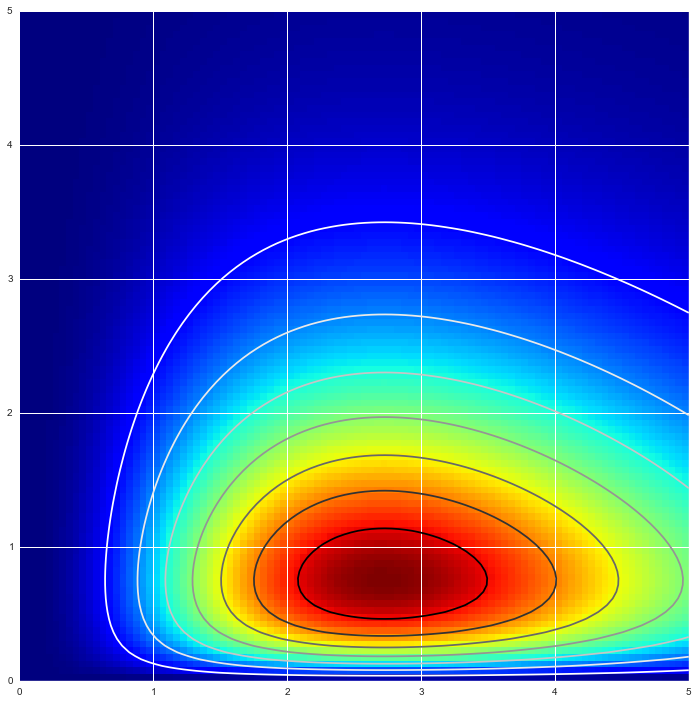

In [243]:
jet = sns.plt.cm.jet
figsize(12.5, 12)
sns.plt.subplot(111)
# This is the likelihood times prior, that results in the posterior.
sns.plt.contour(x, y, M * L)
im = sns.plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

In [244]:
import pymc as pm

In [246]:
p = pm.Uniform("p", 0, 1)

# Carmodel

In [ ]:
for i, car in enumerate(cars):
    p = car.position
    v = car.velocity
    maxv = car.max_velocity
    
    if car.velocity < car.max_velocity:
        car.velocity += 1
    
    if i < len(cars):
        d = cars[i + 1].position - car.position
        if car.velocity > d:
            car.velocity -= 1
    
    car.velocity -= 1 if np.random.rand() < p else 0
    car.position += car.velocity

    
    